<a href="https://colab.research.google.com/github/pathilink/sp_global_bootcamp/blob/main/10_projeto_final/notebook/projeto_final_modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final - Modelagem Preditiva

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import chi2_contingency

## Dado

In [2]:
df_cancer = pd.read_csv('/content/drive/MyDrive/WoMakersCode/Bootcamp S&P Global/Projeto Final/global_cancer_patients_2015_2024_cleaned.csv')
df_cancer.head()

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score,age_range
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92,70-79
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65,30-39
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84,80-89
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12,40-49
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62,40-49


## Estimar quantos pacientes (casos de câncer) surgiriam em 2025, com base nos dados históricos por ano.

In [3]:
total_por_ano = df_cancer.groupby('Year').size()
total_por_ano

,0
Year,
2015,4601
2016,4655
2017,4629
2018,4495
2019,4636
2020,4679
2021,4561
2022,4481
2023,4512


In [4]:
crescimento_anual = total_por_ano.diff().dropna()
crescimento_anual

,0
Year,
2016,54.0
2017,-26.0
2018,-134.0
2019,141.0
2020,43.0
2021,-118.0
2022,-80.0
2023,31.0
2024,98.0


In [5]:
# desvio padrão do crescimento histórico
std_crescimento = crescimento_anual.std()
std_crescimento

96.27954092121544

In [6]:
crescimento_medio = crescimento_anual.mean()
crescimento_medio

np.float64(1.0)

In [7]:
# Intervalo de Confiança: usando 1.96 como z-score para 95% de confiança (assumindo normalidade)

z = 1.96  # 95% de confiança
ultimo_valor = total_por_ano.loc[2024]
anos_futuros = range(2025, 2031)
projecao = []

for i, year in enumerate(anos_futuros, start=1):
    esperado = ultimo_valor + crescimento_medio
    erro_padrao = std_crescimento * np.sqrt(i)
    intervalo_inferior = esperado - z * erro_padrao
    intervalo_superior = esperado + z * erro_padrao
    projecao.append((year, int(esperado), intervalo_inferior, intervalo_superior))
    ultimo_valor = esperado


In [8]:
projecao_df = pd.concat([
    total_por_ano[total_por_ano.index <= 2024].rename('casos').to_frame(),
    pd.DataFrame(projecao, columns=['ano', 'casos', 'lower', 'upper']).set_index('ano')
])

projecao_df['tag'] = projecao_df.index.to_series().apply(
    lambda x: 'ocorrido' if x <= 2024 else 'projetado'
)

projecao_df

,casos,lower,upper,tag
2015,4601,NaN,NaN,ocorrido
2016,4655,NaN,NaN,ocorrido
2017,4629,NaN,NaN,ocorrido
2018,4495,NaN,NaN,ocorrido
2019,4636,NaN,NaN,ocorrido
2020,4679,NaN,NaN,ocorrido
2021,4561,NaN,NaN,ocorrido
2022,4481,NaN,NaN,ocorrido
2023,4512,NaN,NaN,ocorrido
2024,4610,NaN,NaN,ocorrido


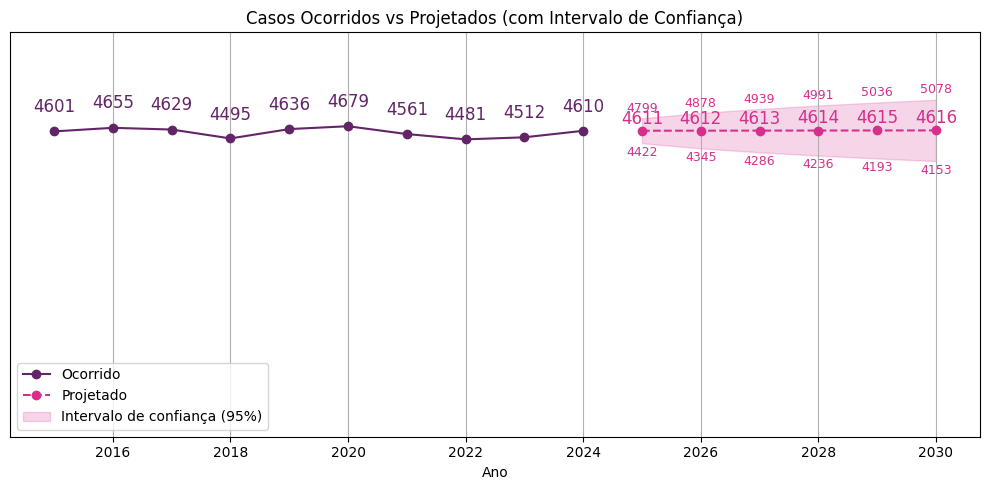

In [9]:
ocorrido = projecao_df[projecao_df['tag'] == 'ocorrido']
projetado = projecao_df[projecao_df['tag'] == 'projetado']

plt.figure(figsize=(10, 5))

# Linhas
plt.plot(ocorrido.index, ocorrido['casos'], label='Ocorrido', color='#622567', marker='o')
plt.plot(projetado.index, projetado['casos'], label='Projetado', color='#D62F8C', linestyle='--', marker='o')

# Intervalo de confiança
plt.fill_between(
    projetado.index,
    projetado['lower'],
    projetado['upper'],
    color='#D62F8C',
    alpha=0.2,
    label='Intervalo de confiança (95%)'
)

# Texto nos pontos
for i, v in ocorrido['casos'].items():
    plt.text(i, v * 1.05, str(v), ha='center', va='bottom', fontsize=12, color='#622567')

# for i, v in projetado['casos'].items():
#     plt.text(i, v * 1.01, str(v), ha='center', va='bottom', fontsize=12, color='#D62F8C')

for i in projetado.index:
    valor = projetado.loc[i, 'casos']
    lower = projetado.loc[i, 'lower']
    upper = projetado.loc[i, 'upper']

    # Valor principal (esperado)
    plt.text(i, valor * 1.01, f'{int(valor)}', ha='center', va='bottom', fontsize=12, color='#D62F8C')

    # Valor inferior
    plt.text(i, lower * 0.99, f'{int(lower)}', ha='center', va='top', fontsize=9, color='#D62F8C')

    # Valor superior
    plt.text(i, upper * 1.01, f'{int(upper)}', ha='center', va='bottom', fontsize=9, color='#D62F8C')


# Ajustes
max_val = max(projetado['upper'].max(), ocorrido['casos'].max())
plt.ylim(0, max_val * 1.2)


plt.title('Casos Ocorridos vs Projetados (com Intervalo de Confiança)')
plt.xlabel('Ano')
plt.ylabel('')
plt.yticks([])
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


## Qual o impacto das variáveis (análise e comparação)

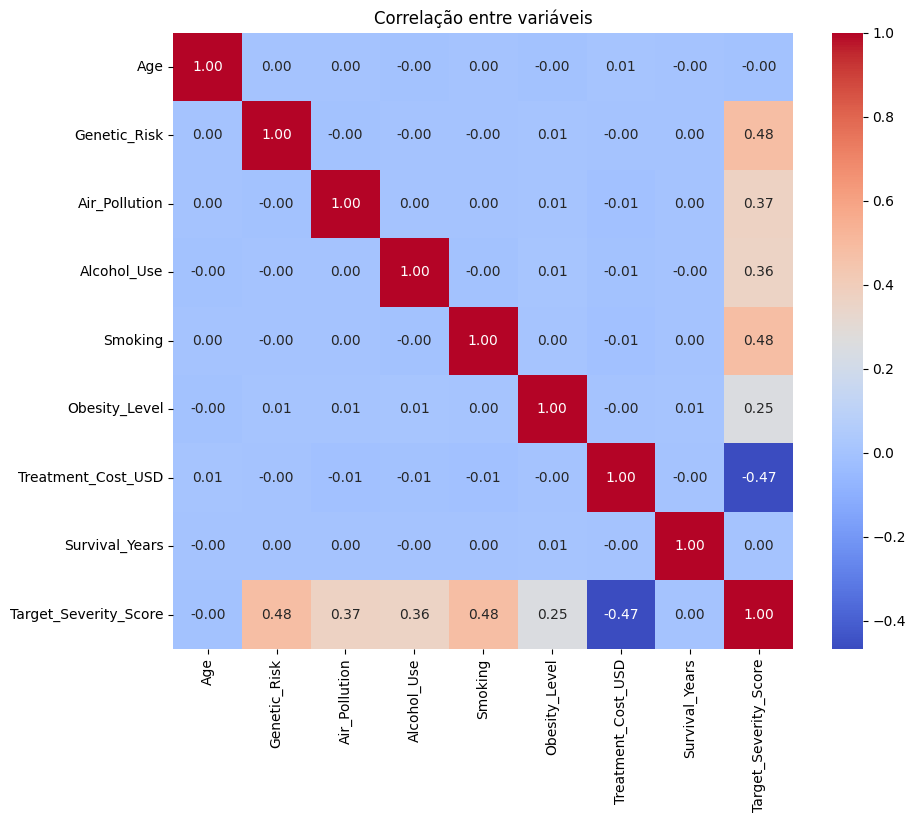

In [10]:
num_cols = [
    'Age', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking',
    'Obesity_Level', 'Treatment_Cost_USD', 'Survival_Years',
    'Target_Severity_Score'
]

corr = df_cancer[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis")
plt.show()


In [11]:
# regressão linear múltipla
X = df_cancer[['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level']]
y = df_cancer['Target_Severity_Score']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Target_Severity_Score   R-squared:                       0.792
Model:                               OLS   Adj. R-squared:                  0.792
Method:                    Least Squares   F-statistic:                 3.494e+04
Date:                   Mon, 07 Jul 2025   Prob (F-statistic):               0.00
Time:                           01:16:27   Log-Likelihood:                -37426.
No. Observations:                  45859   AIC:                         7.486e+04
Df Residuals:                      45853   BIC:                         7.492e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9248      0.010     90.722      0.000       0.905       0.945
Genetic_Risk      0.2002      0.001    226.171      0.000       0.198       0.202
Air_Pollution     0.1516      0.001    171.434      0.000       0.150       0.153
Alcohol_Use       0.1510      0.001    170.401      0.000       0.149       0.153
Smoking           0.2018      0.001    227.573      0.000       0.200       0.204
Obesity_Level     0.1004      0.001    113.666      0.000       0.099       0.102
==============================================================================
Omnibus:                    39137.306   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2733.953
Skew:                          -0.004   Prob(JB):                         0.00
Kurtosis:                       1.804   Cond. No.                         46.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**1. Qualidade do Modelo**

| Métrica                                | Interpretação                                                                                                                     |
| -------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **R-squared: 0.792**                   | O modelo explica **79,2% da variância** do `Target_Severity_Score`. Isso é considerado **muito bom** para dados de saúde pública. |
| **Adj. R-squared: 0.792**              | Mesmo valor ajustado pelo número de variáveis. Isso indica que os preditores realmente agregam valor.                             |
| **F-statistic: 3.494e+04 (p = 0.000)** | O modelo como um todo é **estatisticamente significativo**. A hipótese nula (de que todos os coeficientes são zero) é rejeitada.  |
| **No. Observations: 45.859**           | Tamanho amostral bastante robusto.                                                                                                |


**2. Coeficientes (impacto das variáveis)**

| Variável           | Coef.       | Interpretação prática (mantendo as outras constantes)                                                                                          |
| ------------------ | ----------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **const**          | 0.9280      | Valor esperado do `Target_Severity_Score` quando todas as variáveis independentes forem zero. Pode ou não ter interpretação prática.           |
| **Genetic\_Risk**  | **+0.2005** | Para cada ponto adicional no risco genético, o escore de severidade aumenta 0.20 unidades. É o preditor **mais impactante junto com Smoking**. |
| **Air\_Pollution** | +0.1516     | Poluição do ar tem efeito positivo relevante no aumento da severidade do câncer.                                                               |
| **Alcohol\_Use**   | +0.1510     | Maior consumo de álcool está associado a um aumento na severidade.                                                                             |
| **Smoking**        | **+0.2018** | Fumar tem o **maior impacto individual** junto com risco genético. Aumenta significativamente o escore.                                        |
| **Obesity\_Level** | +0.1004     | Também contribui de forma positiva, mas com menor intensidade.                                                                                 |

📌 Todos os valores de p são 0.000, ou seja, todas as variáveis são estatisticamente significativas (rejeitamos a hipótese nula de que o coeficiente é zero).

**3. Diagnósticos do Modelo**

| Métrica                                     | Interpretação                                                                                                                                                         |
| ------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Durbin-Watson: 2.002**                    | Teste de autocorrelação dos resíduos. Valor próximo de 2 → **sem autocorrelação**. ✅                                                                                  |
| **Omnibus / Jarque-Bera / Skew / Kurtosis** | Os testes indicam que **os resíduos não seguem perfeitamente uma distribuição normal**, o que pode afetar testes inferenciais (mas pouco preocupante com N = 50.000). |

**Resumo**

O modelo é estatisticamente significativo e explica cerca de 79% da variação na severidade do câncer. Todos os cinco fatores analisados (risco genético, poluição do ar, uso de álcool, tabagismo e obesidade) têm um efeito positivo e estatisticamente significativo sobre a severidade do câncer. O risco genético e o tabagismo são os preditores mais fortes, enquanto obesidade tem o menor impacto entre os incluídos. Os resíduos não seguem perfeitamente a normalidade, mas não há autocorrelação detectada.

In [12]:
df_cancer.head()

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score,age_range
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92,70-79
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65,30-39
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84,80-89
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12,40-49
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62,40-49


## Diferença significativa entre incidência por gênero e tipo de câncer

In [13]:
# Tabela cruzada
cross_tab = pd.crosstab(df_cancer['Cancer_Type'], df_cancer['Gender'])

# Teste qui-quadrado
chi2, p, dof, expected = chi2_contingency(cross_tab)

print(f"Valor-p: {p}")
if p < 0.05:
    print("Existe diferença significativa entre os sexos em relação aos tipos de câncer.")
else:
    print("Não há diferença estatisticamente significativa.")


Valor-p: 0.0
Existe diferença significativa entre os sexos em relação aos tipos de câncer.
